## Задание
Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠).  
Считаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠.  
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠. 

Задача
1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
# импорт библиотек

import pandahouse
import seaborn as sns
from scipy import stats
from random import sample
import numpy as np

In [2]:
# для соединения с БД

connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': '*********',
'user': '********',
'database': 'simulator_20230220'
}

## Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [3]:
## Считаем общий CTR в контрольной группе (0) 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

q_CTRcontrol_0 = """
SELECT
    SUM(action = 'like')/SUM(action = 'view') as CTRcontrol
FROM
    simulator_20230220.feed_actions
WHERE
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (0)
"""

CTRcontrol_0 = pandahouse.read_clickhouse(q_CTRcontrol_0, connection=connection).iat[0, 0]
CTRcontrol_0

0.208236122629163

In [4]:
# достаем пользователей из групп 0 и 3 и их характеристики

q_groups_0_3 = """
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (0,3)
GROUP BY
    exp_group,
    user_id
"""
df_groups_0_3 = pandahouse.read_clickhouse(q_groups_0_3, connection=connection)

df_groups_0_3.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [5]:
# добавляем вычисляемую колонку 

df_groups_0_3['linearized_likes'] = df_groups_0_3['likes'] - df_groups_0_3['views'] * CTRcontrol_0
df_groups_0_3.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666
2,0,4944,8,41,0.195122,-0.537681
3,0,4504,5,15,0.333333,1.876458
4,0,121508,18,88,0.204545,-0.324779


### Тест на ctr

In [6]:
#T-тест на CTR

stats.ttest_ind(df_groups_0_3[df_groups_0_3.exp_group == 0].ctr,
                df_groups_0_3[df_groups_0_3.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

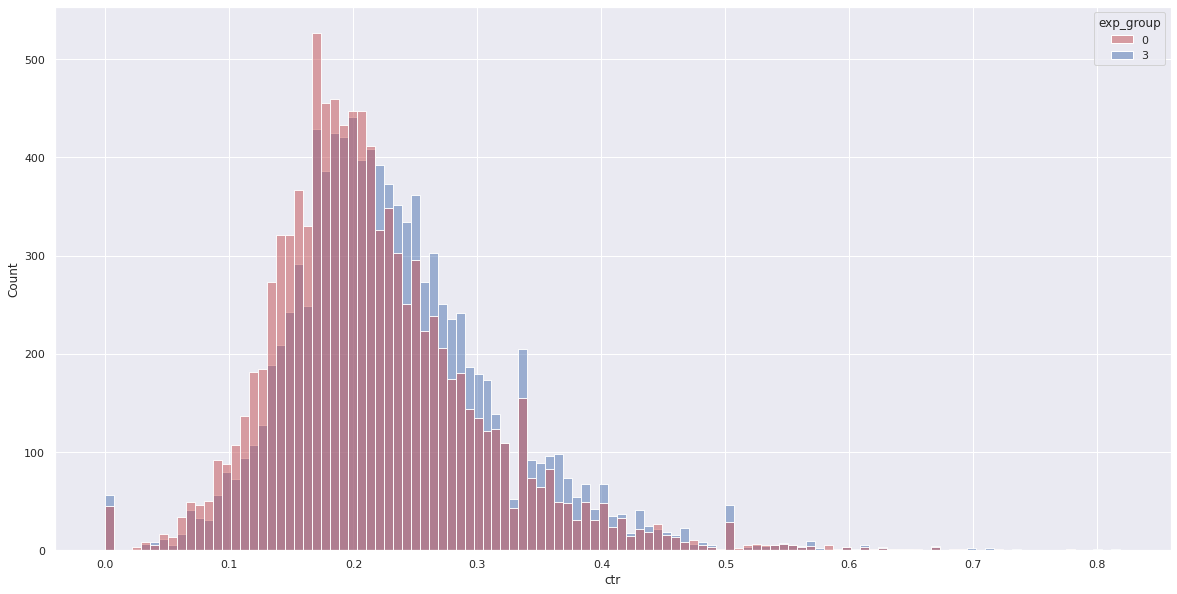

In [7]:
sns.set(rc={'figure.figsize':(20,10)})

groups_0_3_ctr = sns.histplot(data = df_groups_0_3,
                              x='ctr',
                              hue='exp_group',
                              palette = ['r', 'b'], alpha=0.5,
                              kde=False)

### Тест на линеаризованных лайках

In [8]:
#T-тест на линеаризованных лайках

stats.ttest_ind(df_groups_0_3[df_groups_0_3.exp_group == 0].linearized_likes,
                df_groups_0_3[df_groups_0_3.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

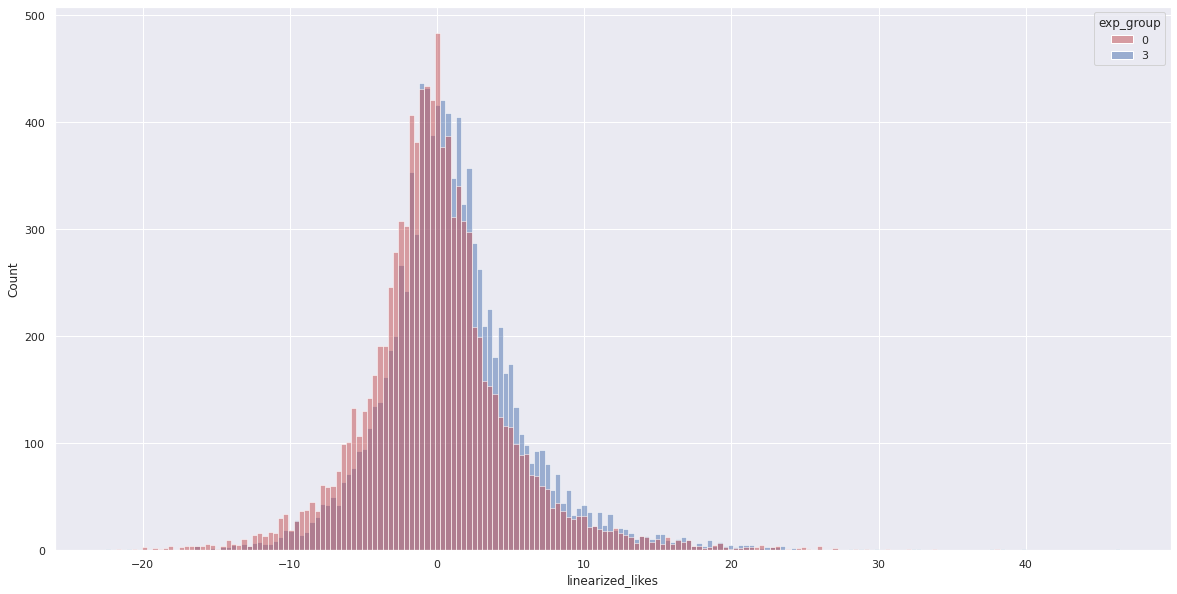

In [9]:
groups_0_3_lin = sns.histplot(data = df_groups_0_3,
                              x='linearized_likes',
                              hue='exp_group',
                              palette = ['r', 'b'], alpha=0.5,
                              kde=False)

**Т-тест на CTR показал p-value 1.05e-43, что уже очень маленькая величина.  
Т-тест на линеаризованных лайках показал p-value еще меньше (5.49e-52).**

## Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [10]:
## Считаем общий CTR в контрольной группе (1)

q_CTRcontrol_1 = """
SELECT
    SUM(action = 'like')/SUM(action = 'view') as CTRcontrol
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (1)
"""

CTRcontrol_1 = pandahouse.read_clickhouse(q_CTRcontrol_1, connection=connection).iat[0, 0]
CTRcontrol_1

0.2080268049012624

In [11]:
# достаем пользователей из групп 1 и 2 и их характеристики

q_groups_1_2 = """
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (1,2)
GROUP BY
    exp_group,
    user_id
"""
df_groups_1_2 = pandahouse.read_clickhouse(q_groups_1_2, connection=connection)

df_groups_1_2.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [12]:
# добавляем вычисляемую колонку 

df_groups_1_2['linearized_likes'] = df_groups_1_2['likes'] - df_groups_1_2['views'] * CTRcontrol_1
df_groups_1_2.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,109963,3,15,0.200000,-0.120402
1,1,26117,32,141,0.226950,2.668221
2,1,138232,18,73,0.246575,2.814043
3,1,26295,33,122,0.270492,7.620730
4,1,18392,7,32,0.218750,0.343142


### Тест на ctr

In [13]:
#T-тест на CTR

stats.ttest_ind(df_groups_1_2[df_groups_1_2.exp_group == 1].ctr,
                df_groups_1_2[df_groups_1_2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

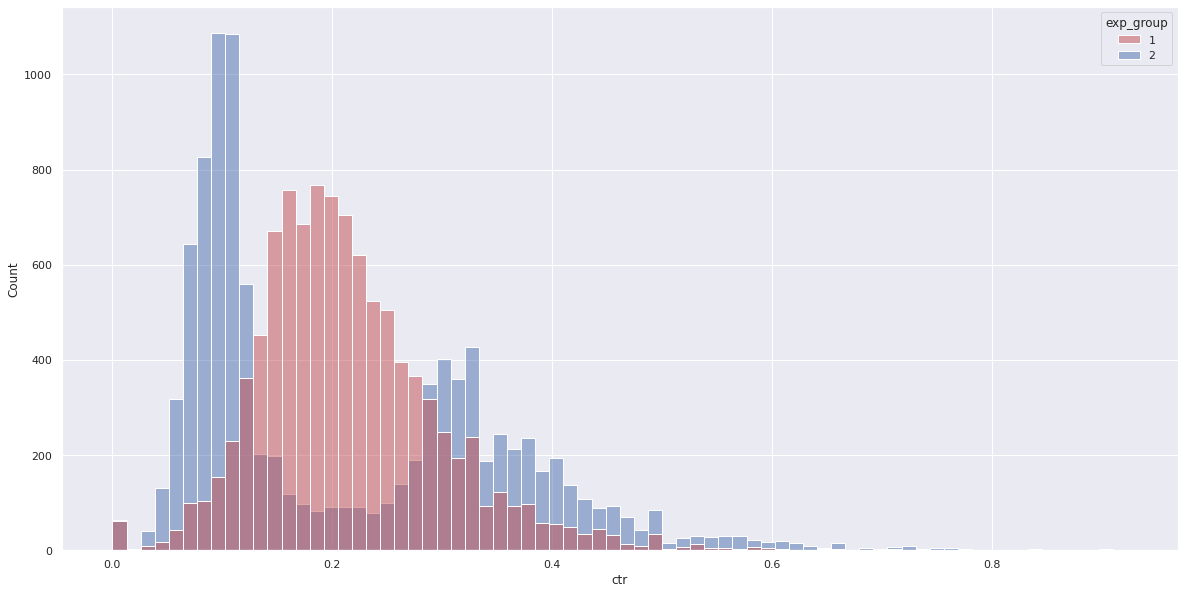

In [14]:
groups_1_2_ctr = sns.histplot(data = df_groups_1_2,
                              x='ctr',
                              hue='exp_group',
                              palette = ['r', 'b'], alpha=0.5,
                              kde=False)

### Тест на линеаризованных лайках

In [15]:
#T-тест на линеаризованных лайках

stats.ttest_ind(df_groups_1_2[df_groups_1_2.exp_group == 1].linearized_likes,
                df_groups_1_2[df_groups_1_2.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

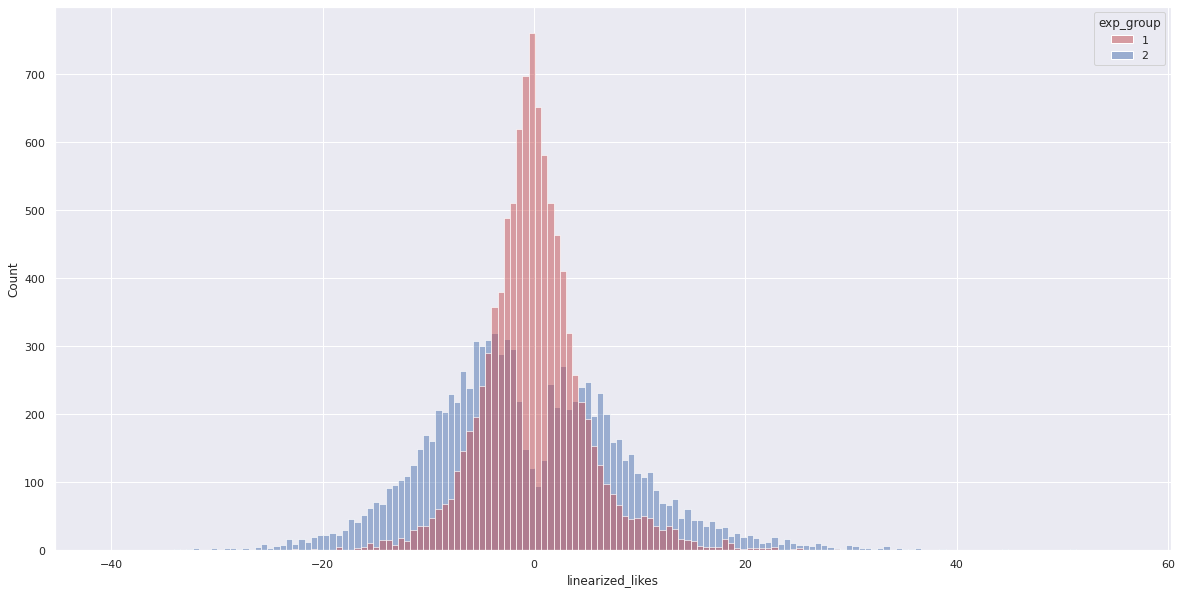

In [16]:
groups_1_2_lin = sns.histplot(data = df_groups_1_2,
                              x='linearized_likes',
                              hue='exp_group',
                              palette = ['r', 'b'], alpha=0.5,
                              kde=False)

**Т-тест на CTR показал p-value ~0.48, что не позволяет отвергнуть нулевую гипотезу.  
Т-тест на линеаризованных лайках показал p-value 9.44e-10, что позволяет отвергнуть нулевую гипотезу. Что оправдано, учитывая бимодальное распределение анализируемых характеристик в группе 2.**

## Обсуждение результатов
**В целом, метрика линеаризованных лайков является более чувствительной и показывает меньшее значение p-value. В случае нормальных унимодальных распределений анализируемых характеристик она подтверждает и подчеркивает результат t-теста на ctr.  
В случае бимодального распределения характеристик (как в группе 2), когда использование t-теста не вполне корректно и показывает р-уровень значимости больше 0.05, использование линеаризованных лайков позволяет получить более адекватный результат.**